In [1]:
import pandas as pd
from sklearn.model_selection import GridSearchCV
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier
import imblearn
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
import numpy as np

##Import the under and oversampling methods
from modeling_preprocessing import filter_df, evaluate_model
from balance_train import smote_1_balanced, smote_2_balanced, adasyn_1_balanced, adasyn_2_balanced
import joblib as jb
import matplotlib.pyplot as plt


ModuleNotFoundError: No module named 'modeling_preprocessing'

In [10]:
#Read in data
### Read input data and transpose to have genes as columns, note, last column is the label for each datapoint ("Cluster WGCNA")
df = pd.read_csv("Govaere_2rlog_visualization_6_subgroups WGCNA_800genes.csv", index_col=0)
#label = df.iloc[:,-1]

##merge label with df
#df = df.merge(label, left_index=True, right_index=True)

### Set up X and y
y = df["Cluster_WGCNA"]
X = df.drop("Cluster_WGCNA", axis=1)

### Data split into train and test set as follows using train_test_split function
##Used 30% of the data for testing, to allow for more data for SMOTE and test
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=0, test_size=0.30) 


In [11]:
X_ada, y_ada = adasyn_1_balanced(X_train, y_train) ##ADASYN 1

In [12]:
X_ada.shape, y_ada.shape

((137, 800), (137,))

In [17]:
#Set seed for reproducibility
np.random.seed(45)

# define search parameters
params = {
    'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    'n_estimators': [100, 200, 300, 400, 500, 600, 700, 800, 1000],
    'bootstrap': [True, False],
    'max_features': ['log2', 'sqrt']
}
# Set RF parameters
cv = 5
random_state = 12345
n_jobs = -1

# create model
model_rf = RandomForestClassifier(n_jobs = n_jobs, verbose = 0, random_state = random_state)

# grid search
grid_search = GridSearchCV(estimator = model_rf, param_grid = params, cv = cv)

# fit model
grid_search.fit(X_ada, y_ada)

# Save the model
model_rf = jb.dump(grid_search, 'RF_gridsearch_finalmodel_800 rlogdata(November 29, 2023).pkl')

# print best parameters
print(grid_search.best_params_)

{'bootstrap': True, 'max_depth': 8, 'max_features': 'sqrt', 'n_estimators': 300}


In [20]:
model = jb.load('RF_gridsearch_finalmodel_800 rlogdata(November 29, 2023).pkl')
model.best_params_

{'bootstrap': True,
 'max_depth': 8,
 'max_features': 'sqrt',
 'n_estimators': 300}

In [79]:
### Fit the model with the best parameters
clf_rf = RandomForestClassifier(bootstrap = True, max_depth=8, max_features='sqrt', n_estimators=300, random_state=random_state)
model = clf_rf.fit(X_ada, y_ada)
#production_model = clf_rf.fit(X, y)
#production_model = jb.dump(production_model, 'RF_gridsearch_productionmodel_800 rlogdata(November 29, 2023).pkl')
model

RandomForestClassifier(max_depth=8, n_estimators=300, random_state=12345)

In [80]:
#predict on test set
y_pred = model.predict(X_test)

In [81]:
#Evaluate the model
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
def evaluate_model(y_test, y_pred):
    acc_score =  accuracy_score(y_test, y_pred)
    cf_mat = confusion_matrix(y_test, y_pred)
    classification_report =  classification_report(y_test, y_pred)
    return acc_score, cf_mat, classification_report


In [82]:
cf_mat = confusion_matrix(y_test, y_pred)
cf_mat

array([[16,  0,  2,  0,  0,  0],
       [ 1, 12,  4,  0,  1,  0],
       [ 2,  1, 11,  0,  0,  0],
       [ 2,  0,  0,  5,  0,  0],
       [ 0,  0,  0,  0,  6,  1],
       [ 0,  0,  0,  0,  0,  1]], dtype=int64)

In [84]:
from collections import Counter
Counter(y_test)

Counter({4: 7, 1: 18, 5: 7, 3: 14, 2: 18, 6: 1})

In [85]:
from sklearn.metrics import balanced_accuracy_score
balanced_accuracy_score(y_test, y_pred)

0.8187830687830688

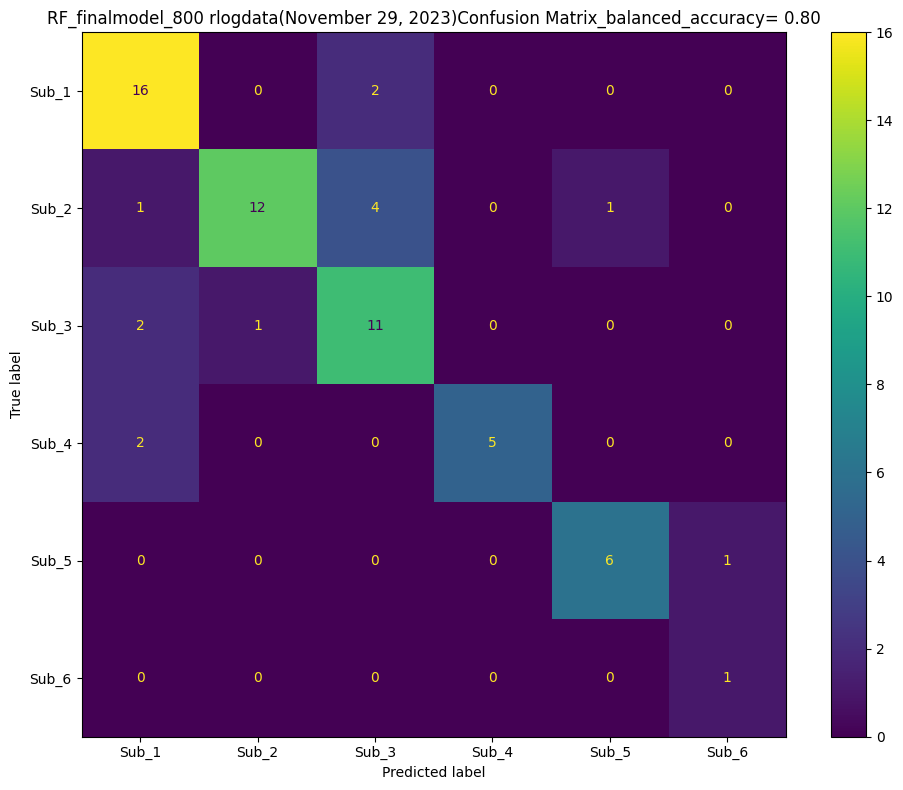

In [86]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Adjust the figure size and layout explicitly
fig, ax = plt.subplots(figsize=(10, 8))  # Adjust the width and height as needed
ConfusionMatrixDisplay(cf_mat, display_labels=['Sub_1', 'Sub_2', 'Sub_3', 'Sub_4', 'Sub_5', 'Sub_6']).plot(ax=ax)
plt.title('RF_finalmodel_800 rlogdata(November 29, 2023)Confusion Matrix_balanced_accuracy= 0.80')

# Adjust the layout to make room for the title
plt.tight_layout()

# Save the figure
plt.savefig('RF_gridsearch_finalmodel_800 rlogdata(November 29, 2023).png')

# Display the figure
plt.show()



In [87]:
gene_list = pd.read_csv("Top_800_genes.csv")


In [88]:
##Other datasets predictions
Hoang = pd.read_csv('Hoang_2rlog_visualization.csv', index_col=0).T
FFPE = pd.read_csv('FFP_2rlog_visualization.csv', index_col=0).T

In [89]:
#Read datasets to predict
Hoang = filter_df(df=Hoang, gene_list=gene_list['Ens_id'])
FFPE = filter_df(df=FFPE, gene_list=gene_list['Ens_id'])

In [90]:
Hoang_prediction = model.predict(Hoang)
Counter(Hoang_prediction)

Counter({2: 52, 3: 22, 1: 3, 6: 1})

In [93]:
FFPE_prediction = model.predict(FFPE)
Counter(FFPE_prediction)

Counter({3: 6, 2: 48, 5: 4, 1: 2, 4: 1, 6: 6})

In [94]:
## Write prediction for samples of other datasets
hoang_samples = pd.DataFrame(Hoang_prediction, columns=['Prediction'], index=Hoang.index)
FFPE_samples = pd.DataFrame(FFPE_prediction, columns=['Prediction'], index=FFPE.index)

In [96]:
total_samples_RNAseq = pd.concat([hoang_samples, FFPE_samples])
total_samples_RNAseq.to_csv('RF_800_genes_ADASYN_1_predictions.csv')